In [1]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
#"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv"
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

In [35]:
# salmon_data = pd.read_csv(r"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv")
# salmon_data.head()
# salmon_copy = salmon_data # Create a copy for us to work with 
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data # Create a copy for us to work with 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, 
          inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
#     print(salmon_copy)
    king_data = salmon_copy.filter(["date","king"], axis=1)
    print(king_data)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [36]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/data.csv'
    king_all_copy, king_data= load_data(ismael_path)
    print(king_all_copy)

            date  king
0     1938-05-01   201
1     1938-05-02   227
2     1938-05-03    78
3     1938-05-04    37
4     1938-05-05    29
...          ...   ...
24729 2021-04-28  2433
24730 2021-04-29  4782
24731 2021-04-30  4641
24732 2021-05-01  2087
24733 2021-05-02  2517

[24734 rows x 2 columns]
            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [64]:
def create_train_test(king_all):
    king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
    king_training = king_all[king_training_parse]
    king_training = king_training.reset_index()
    king_training = king_training.drop('index', axis=1)
    
    king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
    king_test = king_all[king_test_parse]
    king_test = king_test.reset_index()
    king_test = king_test.drop('index', axis=1)
    print(king_test.shape)
    
    # Normalizing Data
    king_training[king_training["king"] < 0] = 0 
    print('max val king_train:')
    print(max(king_training['king']))
    king_test[king_test["king"] < 0] = 0
    print('max val king_test:')
    print(max(king_test['king']))
    king_train_pre = king_training["king"].to_frame()
    king_test_pre = king_test["king"].to_frame()
    scaler = MinMaxScaler(feature_range=(0, 1))
    king_train_norm = scaler.fit_transform(king_train_pre)
    king_test_norm = scaler.fit_transform(king_test_pre)
    print(king_test_norm.shape)
    #king_train_norm = (king_training["king"] - np.min(king_training["king"])) / (np.max(king_training["king"]) - np.min(king_training["king"]))
    #print(type(king_train_norm))
    #king_train_norm = king_train_norm.to_frame()
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    y_test_not_norm = []
    y_train_not_norm = []
    
    # Todo: Experiment with input size of input (ex. 30 days)
    
    for i in range(180,22545): # 30
        x_train.append(king_train_norm[i-180:i])
        y_train.append(king_train_norm[i])
    for i in range(180, 1824):
        x_test.append(king_test_norm[i-180:i])
        y_test.append(king_test_norm[i])
    
    # make y_test_not_norm
    for i in range(180, 1824):
        y_test_not_norm.append(king_test['king'][i])
    for i in range(180,22545): # 30
        y_train_not_norm.append(king_training['king'][i])
        
    return x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm

In [139]:
x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm = create_train_test(king_all_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test_not_norm = np.array(y_test_not_norm)
print(y_test.shape)
y_test_not_norm = y_test_not_norm.reshape((y_test_not_norm.shape[0], 1))
print(y_test_not_norm.shape)
y_train_not_norm = np.array(y_train_not_norm)
y_train_not_norm = y_train_not_norm.reshape((y_train_not_norm.shape[0], 1))
print(y_train_not_norm.shape)
print(y_train.shape)


(1824, 2)
max val king_train:
67521
max val king_test:
32446
(1824, 1)
(1644, 1)
(1644, 1)
(22365, 1)
(22365, 1)


In [128]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
    
def plot_loss(history):
    plt.plot(history_GRU.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    
def day_to_year(day_preds):
    day_preds = day_preds[183:]
    year_preds = []
    for i in range(365, len(day_preds), 365):   
        salmon_count = np.sum(day_preds[i - 365:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

In [129]:
def create_single_layer_rnn_model(x_train, y_train, x_test, y_test, scaler):
    '''
    create single layer rnn model trained on x_train and y_train
    and make predictions on the x_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # fit the RNN model
    history = model.fit(x_train, y_train, epochs=1, batch_size=64)

    print("predicting")
    # Finalizing predictions
    RNN_train_preds = model.predict(x_train)
    RNN_test_preds = model.predict(x_test)
    
    #Descale
    RNN_train_preds = scaler.inverse_transform(RNN_train_preds)
    y_train = scaler.inverse_transform(y_train)
    RNN_test_preds = scaler.inverse_transform(RNN_test_preds)
    RNN_test_preds = RNN_test_preds.astype(np.int64)
    y_test = scaler.inverse_transform(y_test)
#     RNN_salmon_count = (RNN_preds * (np.max(king_training["king"]) - np.min(king_training["king"])) + np.min(king_training["king"])).astype(np.int64)

# why are we normalizing the test and train set, then un-normalizing (maybe this can cause problems in the sense tht we are
# not comparing our preds to the proper y values)
    return model, RNN_train_preds, RNN_test_preds, history, y_train, y_test

In [73]:
def create_GRU_model(x_train, y_train, x_test, y_test, scaler):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape= (x_train.shape[1],1), activation='tanh'))
    #regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
    #regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dense(units=1))

    # Compiling the RNN
    regressorGRU.compile(optimizer = 'adam',loss = 'mean_squared_error')
    # Fitting to the training set
    history = regressorGRU.fit(x_train, y_train, epochs=3, batch_size=150)
    
    # Predictions 
    GRU_train_predict = regressorGRU.predict(x_train)
    GRU_test_predict = regressorGRU.predict(x_test)

    # Descale 
    GRU_train_predict = scaler.inverse_transform(GRU_train_predict)
    y_train = scaler.inverse_transform(y_train)
    GRU_test_predict = scaler.inverse_transform(GRU_test_predict)
    GRU_test_predict = GRU_test_predict.astype(np.int64)
    y_test = scaler.inverse_transform(y_test)
    
    return regressorGRU, GRU_train_predict, GRU_test_predict, history, y_train, y_test

In [74]:
print(x_train.shape)

(22365, 180, 1)


In [24]:
def simple_NN(x_train, y_train, x_test, king_training): 
    '''
    create a simple feedforward neural network trained on X_train
    and Y_train and make predictions on the X_test
    '''
    simpleNN = Sequential()
    simpleNN.add(Dense(10, activation='relu', input_shape= (x_train.shape[1],1)))
    simpleNN.add(Dense(1))
    simpleNN.compile(optimizer = 'adam', loss= 'mean_squared_error')

    # fit model 
    simpleNN.fit(x_train, y_train, epochs = 5, batch_size= 150)
    simpleNN_predicts = simpleNN.predict(x_test)

    # Denormalize 

    return simple_NN, simpleNN_predicts

In [105]:
def create_LSTM_model(x_train, y_train, x_test, y_test): 
    '''
    Create LSTM model trained on X_train and Y_train
    and make predictions on the X_test data
    '''
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(5, input_shape=(x_train.shape[1],1)))
    LSTM_model.add(Dense(1))
    LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
    history_LSTM = LSTM_model.fit(x_train, y_train, epochs=5, batch_size=150, verbose=2)
    
    train_preds = LSTM_model.predict(x_train)
    test_preds = LSTM_model.predict(x_test)
    train_preds = scaler.inverse_transform(train_preds)
    test_preds = scaler.inverse_transform(test_preds)
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)
    
    return LSTM_model, test_preds, train_preds, y_test, y_train, history_LSTM

In [130]:
# global var for baseline
y_test_year = day_to_year(y_test)

In [131]:
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
# print(traditional)
y_test_year = y_test_year.astype(np.int64)
# print(y_test_year)
# print(GRU_test_year)

<h1> Single Layer RNN Training and Testing </h1>

In [132]:
# train single_layer_rnn_model
model, RNN_train_preds, RNN_test_preds, history_RNN, y_train, y_test = create_single_layer_rnn_model(x_train, y_train, x_test, y_test, scaler)

350/350 [==============================] - 8s 20ms/step - loss: 6.2389e-04
predicting


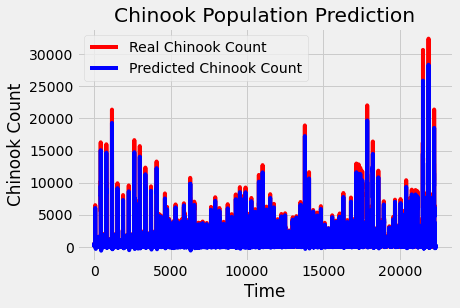

The root mean squared error is 538.2990021243828.
(22365, 1)


In [133]:
# plot single_layer_rnn_model
plot_predictions(y_train, RNN_train_preds)
return_rmse(y_train, RNN_train_preds)
print(RNN_train_preds.shape)

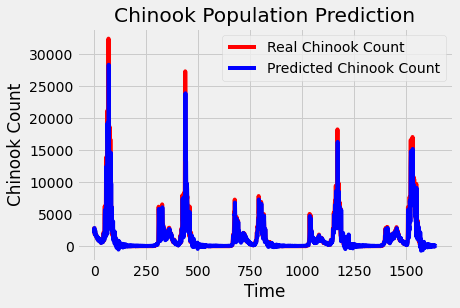

The root mean squared error is 1388.8886107217888.


In [134]:
plot_predictions(y_test, RNN_test_preds)
return_rmse(y_test, RNN_test_preds)

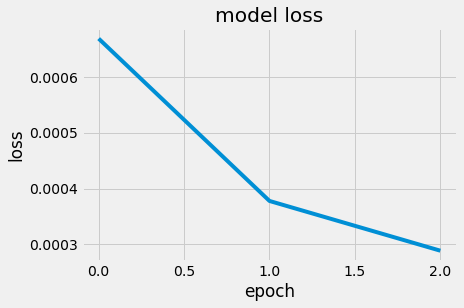

In [135]:
plot_loss(history_RNN)

In [136]:
RNN_test_year = day_to_year(RNN_test_preds)
RNN_test_year

,Count
0,454949
1,323864
2,362292
3,496072


In [138]:
# test RMSE with baseline and RNN
return_rmse(y_test_year, traditional)
return_rmse(y_test_year, RNN_test_year)

The root mean squared error is 402864.86004056.
The root mean squared error is 415079.94283300417.


<h1> GRU training and Testing </h1>

In [75]:
regressorGRU, GRU_train_day, GRU_test_day, history_GRU, y_train, y_test = create_GRU_model(x_train, y_train, x_test, y_test, scaler)

Epoch 1/3
150/150 [==============================] - 23s 139ms/step - loss: 0.0012
Epoch 2/3
150/150 [==============================] - 23s 156ms/step - loss: 4.2297e-04
Epoch 3/3
150/150 [==============================] - 23s 157ms/step - loss: 3.0609e-04


In [102]:
print(GRU_test_day.shape)

(1644, 1)


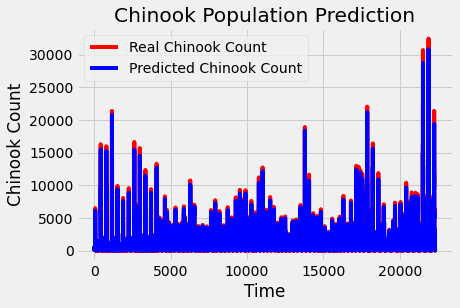

The root mean squared error is 526.6531991529922.


In [77]:
# plot training results
plot_predictions(y_train, GRU_train_day)
return_rmse(y_train, GRU_train_day)

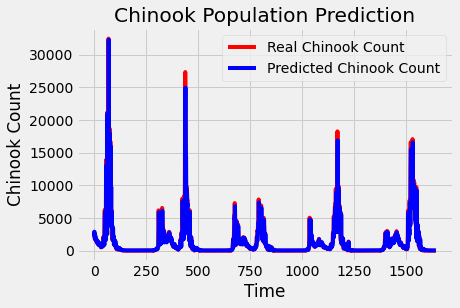

The root mean squared error is 1379.860973197227.


In [118]:
plot_predictions(y_test, GRU_test_day)
return_rmse(y_test, GRU_test_day)

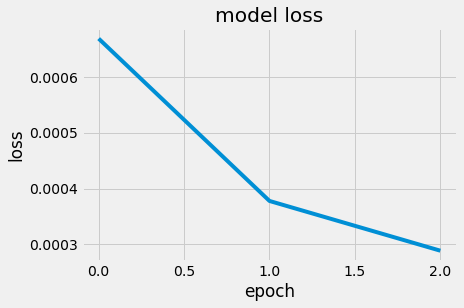

In [119]:
plot_loss(history_GRU)

In [84]:
GRU_test_year = day_to_year(GRU_test_day)
GRU_test_year

,Count
0,465816
1,330156
2,370464
3,509805


In [125]:
# bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Forecast Data Update.csv'
# bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
# bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
# baseline_data = pd.read_csv(bs_ismael_path)
# traditional = pd.DataFrame(baseline_data["Count"])
# # print(traditional)
# y_test_year = y_test_year.astype(np.int64)
# # print(y_test_year)
# # print(GRU_test_year)

In [85]:
# test RMSE with baseline and GRU
return_rmse(y_test_year, traditional)
return_rmse(y_test_year, GRU_test_year)

The root mean squared error is 115830.72196205116.
The root mean squared error is 18520.775159263718.


<h1> LSTM training and Testing </h1>

In [106]:
# running LSTM
LSTM_model, test_preds_LSTM, train_preds_LSTM, y_test, y_train, history_LSTM = create_LSTM_model(x_train, y_train, x_test, y_test)

Epoch 1/5
150/150 - 6s - loss: 0.0011
Epoch 2/5
150/150 - 5s - loss: 6.6492e-04
Epoch 3/5
150/150 - 5s - loss: 5.4706e-04
Epoch 4/5
150/150 - 5s - loss: 4.9241e-04
Epoch 5/5
150/150 - 5s - loss: 4.5163e-04


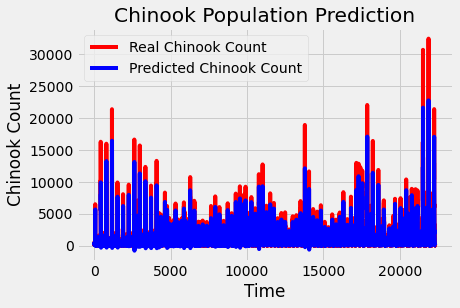

The root mean squared error is 674.5093789015652.


In [112]:
plot_predictions(y_train, train_preds_LSTM)
return_rmse(y_train, train_preds_LSTM)

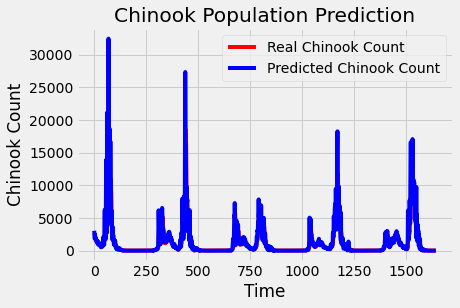

The root mean squared error is 1381.7556983999573.


In [113]:
plot_predictions(test_preds_LSTM, y_test)
return_rmse(y_test, test_preds_LSTM)

In [114]:
print(history_LSTM.history.keys())

dict_keys(['loss'])


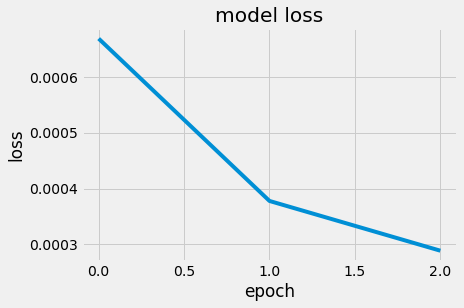

In [115]:
plot_loss(history_LSTM)

In [116]:
# Comparing RMSE to curr Forecasting methods to LSTM
LSTM_test_year = day_to_year(test_preds_LSTM)

In [117]:
# test RMSE with baseline and LSTM
return_rmse(y_test_year, traditional)
return_rmse(y_test_year, LSTM_test_year)

The root mean squared error is 115830.72196205116.
The root mean squared error is 45235.34184605218.
